In [12]:
%matplotlib inline
import numpy as np
MEPS = np.finfo(float).eps
import numpy.linalg as la
import matplotlib.pyplot as plt
import matplotlib

from scipy.optimize import minimize_scalar
from scipy.stats import linregress as linreg

from scipy.interpolate import lagrange, CubicSpline
import numpy.polynomial.polynomial as poly

from halton import halton_sequence

In [196]:
matplotlib.rcParams.update({'font.size': 14})

In [323]:
rbf_dict = {}
shape_labels = []
phs_labels = []

# Shape paramater RBFs

def rbf(r, eps):
    return np.exp(-(eps*r)**2)
rbf_label = 'gaussian'
rbf_dict[rbf_label] = rbf
shape_labels += [rbf_label]

def rbf(r, eps):
    return np.sqrt(1+(eps*r)**2)
rbf_label = 'multiquadric'
rbf_dict[rbf_label] = rbf
shape_labels += [rbf_label]

def rbf(r, eps):
    return 1/(1+(eps*r)**2)
rbf_label = 'inverse quadratic'
rbf_dict[rbf_label] = rbf
shape_labels += [rbf_label]

def rbf(r, eps):
    return 1/np.sqrt(1+(eps*r)**2)
rbf_label = 'inverse multiquadric'
rbf_dict[rbf_label] = rbf
shape_labels += [rbf_label]

# PHS RBFs

def rbf(r,eps):
    return r**2 * np.log(r+MEPS)
rbf_label = '$\\log(r)r^2$'
rbf_dict[rbf_label] = rbf
phs_labels += [rbf_label]

def rbf(r,eps):
    return r**3
rbf_label = '$r^3$'
rbf_dict[rbf_label] = rbf
phs_labels += [rbf_label]

def rbf(r,eps):
    return r**4 * np.log(r+MEPS)
rbf_label = '$\\log(r)r^4$'
rbf_dict[rbf_label] = rbf
phs_labels += [rbf_label]

def rbf(r,eps):
    return r**9
rbf_label = '$r^9$'
rbf_dict[rbf_label] = rbf
phs_labels += [rbf_label]

rbf_labels = shape_labels + phs_labels

In [296]:
def functional(eps, dist_mat, rbf , target_cond, P=None):
    if P == None:
        return np.log( la.cond(rbf(dist_mat, eps)) / target_cond)**2
    else:
        A = rbf(dist_mat, eps)
        deg = len(P[0])-1
        AP = np.block([[A, P],[P.T, np.zeros((deg+1,deg+1))]])
        return np.log( la.cond(AP) / target_cond)**2

def optimize_eps(rbf, dist_mat, P=None, target_cond=10**12):
    n = dist_mat.shape[0]
    eps_guess = 1/np.min(dist_mat+np.diag([np.max(dist_mat)]*n))
    optimization_result = minimize_scalar(functional, 
            bracket=[eps_guess/2, eps_guess*2],
            args=(dist_mat, rbf, target_cond, P))
    return np.abs(optimization_result['x'])

def rbf_interp(xs, fs, zs, rbf, eps=1, optimize_shape=False, target_cond=10**12, print_cond=False):
    dist_mat = np.abs(np.subtract.outer(xs,xs))
    if optimize_shape:
        eps = optimize_eps(rbf, dist_mat)
    A = rbf(dist_mat, eps)
    A_cond = la.cond(A)
    if print_cond:
        print('log Cond(A)= %g' % ( np.log(A_cond)/np.log(10) ) )
    cs = la.solve(A, fs)
    A = rbf(np.abs(np.subtract.outer(zs,xs)), eps)
    return A @ cs, eps, A_cond

def rbf_interp_poly(xs, fs, zs, rbf, deg=0, eps=1, optimize_shape=False, target_cond=10**12, print_cond=False):
    n = len(xs)
    P = xs.reshape((n,1)) ** np.arange(deg+1).reshape((1,deg+1))
    dist_mat = np.abs(np.subtract.outer(xs,xs))
    if optimize_shape:
        eps = optimize_eps(rbf, dist_mat)
    A = rbf(dist_mat, eps)
    AP = np.block([[A, P],[P.T, np.zeros((deg+1,deg+1))]])
    AP_cond = la.cond(AP)
    if print_cond:
        print('log Cond(AP)= %g' % ( np.log(AP_cond)/np.log(10) ) )
    cs = la.solve(AP, np.block([fs, np.zeros(deg+1)]) )
    A = rbf(np.abs(np.subtract.outer(zs,xs)), eps)
    P = zs.reshape((len(zs),1)) ** np.arange(deg+1).reshape((1,deg+1))
    AP = np.block([A, P])
    return AP @ cs, eps, AP_cond

In [244]:
def gen_points(a,b, n, kind='equal'):
    if kind == 'halton':
        xs = np.zeros(n)
        xs[1:-1] = halton_sequence(1, (n-2), 1).flatten() #generates n halton points between 0 and 1
        xs[0] = 0 # add the interior points
        xs[-1] = 1
    elif kind == 'equal':
        xs = np.linspace(0,1,n)
    elif kind == 'chebyshev':
        xs = np.cos(np.linspace(np.pi,0,n))
        xs += 1
        xs /= 2
    xs *= (b-a)
    xs += a
    return xs

# Definie a Function

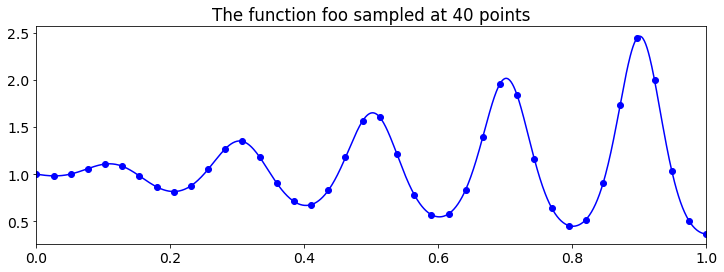

In [332]:
def foo(x):
    return np.exp(-np.cos(10*np.pi*x) * x)

n = 40
xs = gen_points(0,1,n, kind='equal')

zs = np.linspace(0,1, 1000)
fs = foo(zs)

fig = plt.figure(figsize=(12,4))
plt.plot(zs, fs, 'b-')
plt.plot(xs, foo(xs), 'bo')
plt.title('The function foo sampled at %d points' % n)
plt.xlim((0,1))
plt.show()

# Gaussian With Polynomials

epsilon = 58.6849
log cond(AP) = 12.5483
error = 2.04447e-06


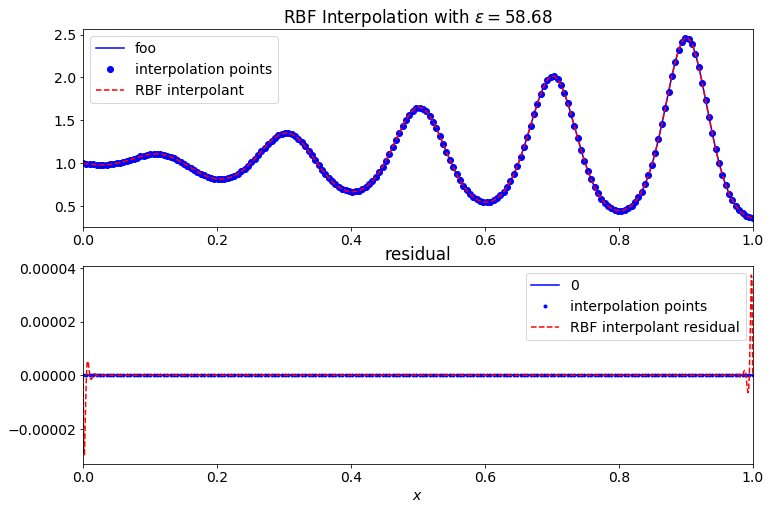

In [265]:
rbf = rbf_dict['gaussian']
n = 200
xs = gen_points(0,1,n, kind='equal')

us, eps, cond = rbf_interp_poly(xs, foo(xs), zs, rbf, deg=5, optimize_shape=True, target_cond=10**15)
print('epsilon = %.4f' % eps)
print('log cond(AP) = %g' % (np.log(cond)/np.log(10)))

err = la.norm(us - fs)/la.norm(fs)
print('error = %g' % err)

fig, axs = plt.subplots(2, sharex=True, figsize=(12,8))

#fig = plt.figure(figsize=(12,8))
axs[0].plot(zs, fs, 'b-')
axs[0].plot(xs, foo(xs), 'bo')
axs[0].plot(zs, us, 'r--')
axs[0].legend(['foo', 'interpolation points', 'RBF interpolant'])
axs[0].set_title('RBF Interpolation with $\\varepsilon=%.2f$'%eps)
axs[0].tick_params(labelbottom=True)
#plt.show()

#fig = plt.figure(figsize=(12,8))
axs[1].plot(zs, [0]*len(zs), 'b-')
axs[1].plot(xs, [0]*len(xs), 'b.')
axs[1].plot(zs, us-fs, 'r--')
axs[1].legend(['0', 'interpolation points', 'RBF interpolant residual'])
axs[1].set_title('residual')
axs[1].set_xlim((0,1))
axs[1].set_xlabel('$x$')

plt.xlim((0,1))
plt.show()

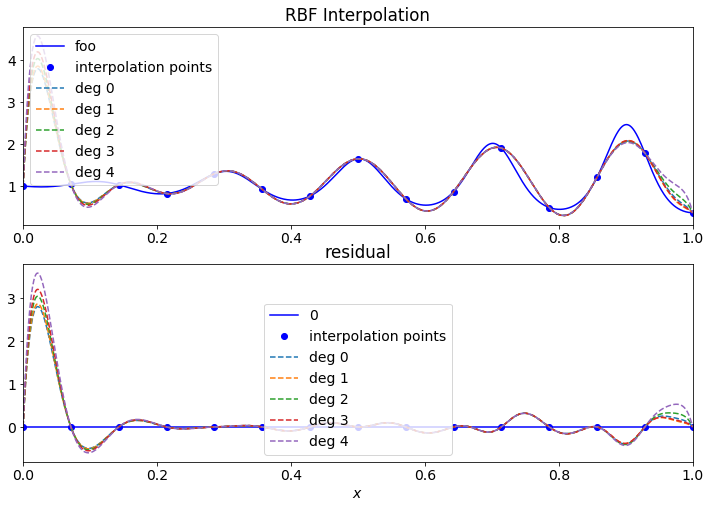

In [297]:
rbf = rbf_dict['gaussian']
degs = range(5)
legend = ['deg %d' % deg for deg in degs]
n = 15
xs = gen_points(0,1,n, kind='equal')

fig, axs = plt.subplots(2, sharex=True, figsize=(12,8))

#fig = plt.figure(figsize=(12,8))
axs[0].plot(zs, fs, 'b-')
axs[0].plot(xs, foo(xs), 'bo')


axs[0].set_title('RBF Interpolation')
axs[0].tick_params(labelbottom=True)
#plt.show()

#fig = plt.figure(figsize=(12,8))
axs[1].plot(zs, [0]*len(zs), 'b-')
axs[1].plot(xs, [0]*len(xs), 'bo')


axs[1].set_title('residual')
axs[1].set_xlim((0,1))
#axs[1].set_ylim((-.05, .05))
axs[1].set_xlabel('$x$')


for deg in degs:
    us, eps, cond = rbf_interp_poly(xs, foo(xs), zs, rbf, deg=deg, optimize_shape=True, target_cond=10**15)
    axs[0].plot(zs, us, '--')
    axs[1].plot(zs, us-fs, '--')
    err = la.norm(us - fs)/la.norm(fs)

axs[0].legend(['foo', 'interpolation points'] + legend, loc='upper left')
axs[1].legend(['0', 'interpolation points'] + legend, loc='lower center')
plt.xlim((0,1))
plt.show()

## Orders

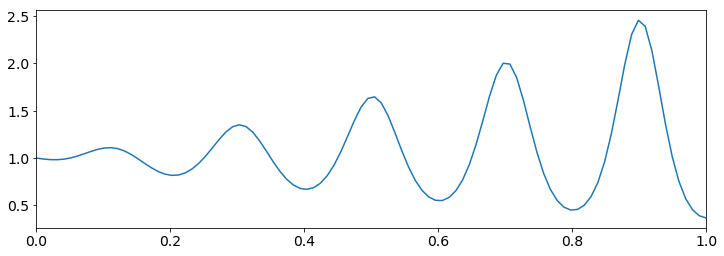

In [336]:
#def foo(x):
#    return x**10 - 3*x**2 + np.sqrt(x) + np.sin(30*x)
plt.figure(figsize=(12,4))
xs = np.linspace(0,1, 1000)
plt.plot(xs, foo(xs))
plt.xlim((0,1))
plt.show()

In [337]:
rbf = rbf_dict['gaussian']
degs = range(5)
legend = ['deg %d' % deg for deg in degs]

ns = [8*2**i for i in range(8)]

errs = [ [] for i in range(len(degs))]
zs = np.linspace(0,1, 1000)
fs = foo(zs)

for n in ns:
    xs = gen_points(0,1,n, kind='equal')
    for deg in degs:
        us, eps, cond = rbf_interp_poly(xs, foo(xs), zs, rbf, deg=deg, optimize_shape=True, target_cond=10**15)
        err = la.norm(us - fs)/la.norm(fs)
        errs[deg].append(err)
    print('Finished n=%d'%n)


Finished n=8
Finished n=16
Finished n=32
Finished n=64
Finished n=128
Finished n=256
Finished n=512
Finished n=1024


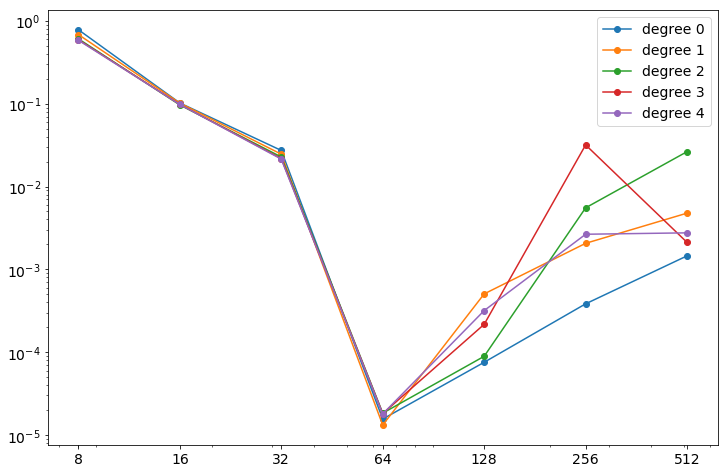

In [343]:
plt.figure(figsize=(12,8))
for deg in degs:
    plt.loglog(ns, errs[deg], 'o-')
plt.legend(['degree %d'%d for d in degs])
plt.xticks(ns,ns)
plt.show()

# PHS RBFs

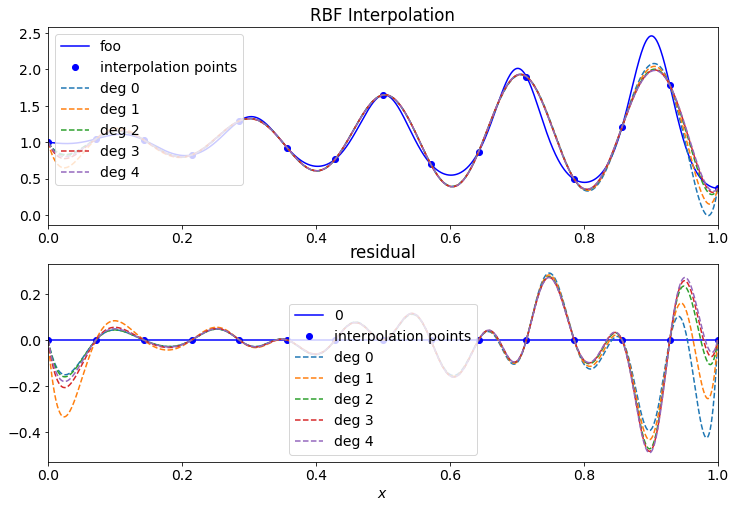

In [340]:
rbf = rbf_dict['$r^9$']
degs = range(5)
legend = ['deg %d' % deg for deg in degs]
n = 15
xs = gen_points(0,1,n, kind='equal')

fig, axs = plt.subplots(2, sharex=True, figsize=(12,8))

#fig = plt.figure(figsize=(12,8))
axs[0].plot(zs, fs, 'b-')
axs[0].plot(xs, foo(xs), 'bo')


axs[0].set_title('RBF Interpolation')
axs[0].tick_params(labelbottom=True)
#plt.show()

#fig = plt.figure(figsize=(12,8))
axs[1].plot(zs, [0]*len(zs), 'b-')
axs[1].plot(xs, [0]*len(xs), 'bo')


axs[1].set_title('residual')
axs[1].set_xlim((0,1))
#axs[1].set_ylim((-.05, .05))
axs[1].set_xlabel('$x$')


for deg in degs:
    us, eps, cond = rbf_interp_poly(xs, foo(xs), zs, rbf, deg=deg, optimize_shape=True, target_cond=10**15)
    axs[0].plot(zs, us, '--')
    axs[1].plot(zs, us-fs, '--')
    err = la.norm(us - fs)/la.norm(fs)

axs[0].legend(['foo', 'interpolation points'] + legend, loc='upper left')
axs[1].legend(['0', 'interpolation points'] + legend, loc='lower center')
plt.xlim((0,1))
plt.show()

In [346]:
rbf = rbf_dict['$r^9$']
degs = range(5)
legend = ['deg %d' % deg for deg in degs]

ns = [8*2**i for i in range(8)]

errs = [ [] for i in range(len(degs))]
zs = np.linspace(0,1, 1000)
fs = foo(zs)

for n in ns:
    xs = gen_points(0,1,n, kind='equal')
    for deg in degs:
        us, eps, cond = rbf_interp_poly(xs, foo(xs), zs, rbf, deg=deg, optimize_shape=False)
        err = la.norm(us - fs)/la.norm(fs)
        errs[deg].append(err)
    print('Finished n=%d'%n)

Finished n=8
Finished n=16
Finished n=32
Finished n=64
Finished n=128
Finished n=256
Finished n=512
Finished n=1024


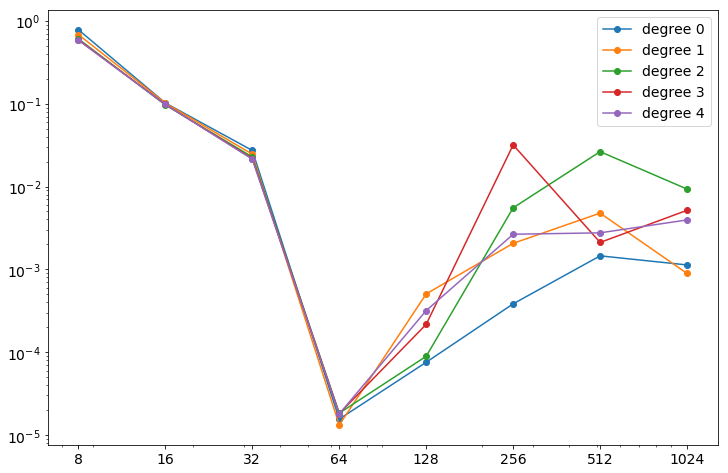

In [347]:
plt.figure(figsize=(12,8))
for deg in degs:
    plt.loglog(ns, errs[deg], 'o-')
plt.legend(['degree %d'%d for d in degs])
plt.xticks(ns,ns)
plt.show()